# Проверка и тесты модели банкротств

In [10]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os import path, getcwd
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import re

# общие константы и функции
idx=pd.IndexSlice # объект для индексации мультииндексного фрейма
strDB_path=path.join('..', 'DB', 'bankrp.sqlite3')

# константы базы данных SQLite3
strNOZA_table='noza' # название таблицы NOZA в базе данных SQLite
strNOZA_agg='noza_ag' # название рабочего  представления для таблицы NOZA в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strNOZA_data_pass='noza_columns' # таблица с названиями колонок для таблицы noza
strSPARK_table='spark' # название таблицы SPARK в базе данных SQLite
strSPARK_agg='spark_ag' # название рабочего  представления для таблицы SPARK в базе данных SQLite (ROA из базы)
strSPARK_agg_roa_calc='spark_ag_roa_calc' # название рабочего  представления для таблицы SPARK (ROA считаем)
strSPARK_data_pass='spark_columns' # таблица с названиями колонок для таблицы SPARK
strLOAN_table='loan' # название таблицы LOAN в базе данных SQLite
strLOAN_data_pass='loan_columns' # таблица с названиями колонок для таблицы loan
strLOAN_agg='loan_agg' # название рабочего  представления для таблицы LOAN в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strBNKRPT_table='bankrp' # название таблицы с фактическими банкротствами
strModeLDATA_table='model_data'  # название таблицы с входными данными для основной модели "Банкротства застройщиков"
strModeLDATA_table_fork='model_data_fork'  # название таблицы с входными данными для основной модели "Банкротства застройщиков"
# ------------

cnWork=sqlite3.connect(strDB_path)

In [11]:
pd_noza=pd.read_sql('select * from {}'.format(strNOZA_table), con=cnWork).set_index('inn')
pd_noza['Input_date']=pd.to_datetime(pd_noza['Input_date'], format='%Y-%m-%d')
pdfG1=pd_noza.reset_index().groupby(['inn', pd.Grouper(key='Input_date', freq='Y')]).agg({'bld_price':sum, 'sq_living':sum})
pd_noza.reset_index().groupby('completion_year').agg({'bld_price':sum, 'sq_living':sum})

,bld_price,sq_living
completion_year,,
2019,24100767685,537160.49
2020,2652271471500,38036354.27
2021,2476434196409,33191477.71
2022,1119356327446,14911061.10
2023,869827098100,7273616.26
2024,352915931314,3182000.71
2025,156589727216,1725628.13
2026,68468061456,689396.74
2027,22380765248,473162.94


In [12]:
%store -r pdf_sp

# pdf_sp
pdfWork=pdf_sp[ [c for c in pdf_sp.columns if not re.search('_t', c)]]
pdfWork

Cancel_date     ROA       Z_A  capital      ROA_      Z_A_  \
inn        year                                                              
0104014512 2012         NaT     NaN       NaN      NaN  0.003000  0.196358   
           2013         NaT     NaN       NaN      NaN  0.002200  0.203161   
           2014         NaT -0.0426  0.797872  10000.0  0.001400  0.194526   
           2015         NaT  0.0041  0.960739  10000.0  0.001400  0.191316   
           2016         NaT  0.0015  0.255651  10000.0  0.001100  0.190117   
...                     ...     ...       ...      ...       ...       ...   
9909127226 2021         NaT     NaN       NaN      NaN  0.005940  0.190325   
           2022         NaT     NaN       NaN      NaN  0.004892  0.188416   
           2023         NaT     NaN       NaN      NaN  0.006084  0.188716   
           2024         NaT     NaN       NaN      NaN  0.005348  0.188548   
           2025         NaT     NaN       NaN      NaN  0.005477  0.188548   

                     LOAN_     ROA_d     Z_A_d    LOAN_d  
inn        year                                           
0104014512 2012   9.100000 -0.001000  0.021733  0.650000  
           2013   9.466667 -0.000800  0.006803  0.366667  
           2014  11.135000 -0.000800 -0.008635  1.668333  
           2015  15.716667  0.000000 -0.003210  4.581667  
           2016  12.592500 -0.000300 -0.001199 -3.124167  
...                    ...       ...       ...       ...  
9909127226 2021   4.725591  0.002998 -0.016676 -2.285520  
           2022   6.327573 -0.001048 -0.001909  1.601983  
           2023   6.569880  0.001192  0.000301  0.242306  
           2024   6.812186 -0.000736 -0.000168  0.242306  
           2025   6.626160  0.000129  0.000000 -0.186027  

[112770 rows x 10 columns]

In [13]:
pdfWork.reset_index()['inn'].unique()

array(['0104014512', '0105003792', '0105008695', ..., '9729055420',
       '9731012872', '9909127226'], dtype=object)

In [79]:


pdf_data=pd.read_sql('select * from {}'.format(strModeLDATA_table), con=cnWork).set_index(['inn', 'year'])
pdf_data_f=pd.read_sql('select * from {}'.format(strModeLDATA_table_fork), con=cnWork).set_index(['inn', 'year'])
pdf_data_f

Y  capital   ROA_mod   Z_A_mod
inn        year                                  
0104014512 2007  0.0  10000.0       NaN       NaN
           2008  0.0  10000.0       NaN       NaN
           2009  0.0  10000.0       NaN       NaN
           2010  0.0  10000.0       NaN       NaN
           2011  0.0  10000.0       NaN       NaN
...              ...      ...       ...       ...
9731012872 2021  0.0  10000.0  0.042677  0.127682
           2022  0.0  10000.0  0.008756  1.005492
           2023  0.0  10000.0  0.025728  1.008272
           2024  0.0  10000.0  0.010945  1.015064
           2025  0.0  10000.0  0.011149  1.015064

[149720 rows x 4 columns]

In [89]:
iRandINNcnt=5

rand_inn=np.random.choice(pdf_data.index.get_level_values('inn'), iRandINNcnt, replace=False)
pdfs=pdf_data.loc[idx[rand_inn, :], :]
pdfsf=pdf_data_f.loc[idx[rand_inn, :], :]
pdf_test=pdfsf[ [c for c in pdfsf.columns if c not in ['Y', 'capital']] ].join(pdfs[[c for c in pdfs.columns if c not in ['Y', 'capital']]])
pdf_test

ROA_mod   Z_A_mod   ROA_par   Z_A_par
inn        year                                        
7704854386 2007       NaN       NaN       NaN       NaN
           2008       NaN  0.413580       NaN       NaN
           2009  0.000100  0.336896  0.000100  0.336896
           2010  0.003200  0.414693  0.003200  0.414693
           2011  0.000500  0.637348  0.000500  0.637348
...                   ...       ...       ...       ...
6670455325 2021  0.042677  0.127682  0.006350 -0.618223
           2022  0.008756  1.005492  0.005302 -0.620132
           2023  0.025728  1.008272  0.006494 -0.619832
           2024  0.010945  1.015064  0.005758 -0.620000
           2025  0.011149  1.015064  0.005887 -0.620000

[95 rows x 4 columns]

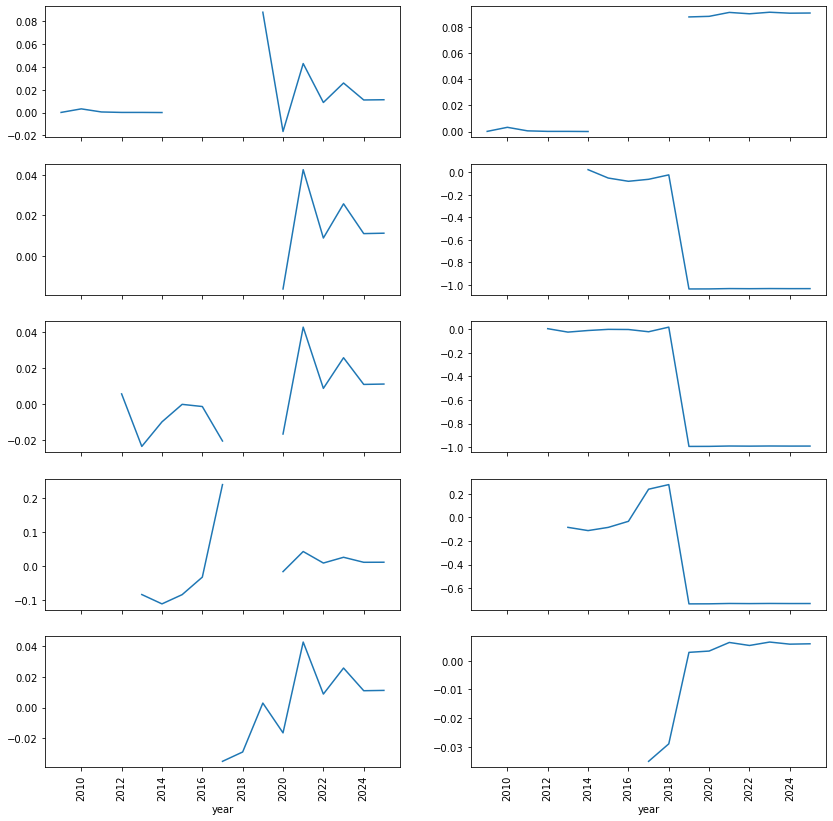

In [90]:
fig_ROA, ax_R=plt.subplots(figsize=(14,14), nrows=iRandINNcnt, ncols=2, sharex=True)
xt=list(pdf_test.index.get_level_values('year'))

for i, inn in enumerate(pdf_test.index.get_level_values('inn').unique()):
    pdf_test.loc[idx[inn, :], idx['ROA_mod']].droplevel('inn').plot.line(ax=ax_R[i, 0], rot=90) # моделирование
    pdf_test.loc[idx[inn, :], idx['ROA_par']].droplevel('inn').plot.line(ax=ax_R[i, 1], rot=90) # раскрученое

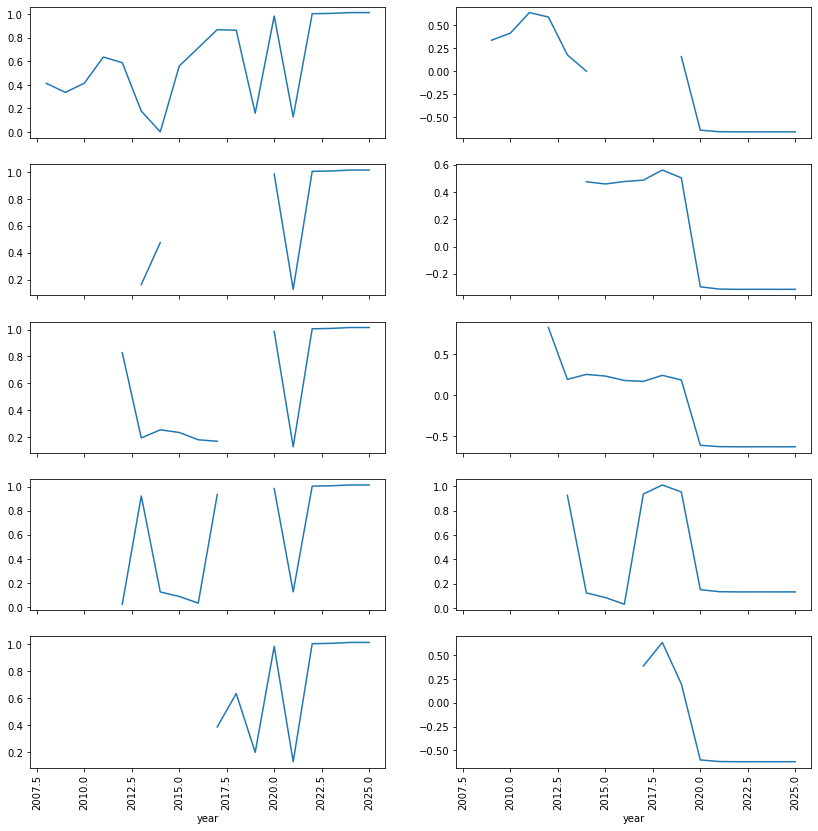

In [91]:
fig_ZA, ax_Z=plt.subplots(figsize=(14,14), nrows=iRandINNcnt, ncols=2, sharex=True)
xt=list(pdf_test.index.get_level_values('year'))

for i, inn in enumerate(pdf_test.index.get_level_values('inn').unique()):
    pdf_test.loc[idx[inn, :], idx['Z_A_mod']].droplevel('inn').plot.line(ax=ax_Z[i, 0], rot=90) # моделирование
    pdf_test.loc[idx[inn, :], idx['Z_A_par']].droplevel('inn').plot.line(ax=ax_Z[i, 1], rot=90) # раскрученое